In [1]:
#!pip install tensorflow==2.7.0

In [2]:
#pip install opencv-python-headless

In [3]:
from distutils import extension
from logging import exception
import os
from datetime import datetime as dt
from regex import E
from sqlalchemy import intersect
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np 
import pathlib
from keras.callbacks import ModelCheckpoint   
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!ls "/content/gdrive/MyDrive/cbisddsm"

Test_output_full  Test_output_mask  Train_output_full  Train_output_mask


In [6]:
# data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Images/Train")
# data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Images/Test')

In [7]:
seed = 43
encoder_input_width = 512
encode_input_channels = 3
encoder_input_shape = (encoder_input_width, encoder_input_width, encode_input_channels)

kernsize = 3
decoder_kernel_size = (kernsize, kernsize)
stride = 2
decoder_strides = (stride, stride)
decoder_padding = "same"
decoder_activation = None
final_layer_filters = 1
final_layer_activation = "sigmoid"

train_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_full"
train_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Train_output_mask"

test_full_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_full"
test_mask_img_dir = "/content/gdrive/MyDrive/cbisddsm/Test_output_mask"
results_dir = "/content/results/fit"
extension = ".png"

target_size = (512, 512)

brightness_delta = 0.3
batch_size = 10

weight_decay = 1e-5

validate = False
loss = "binary_crossentropy"
learning_rate = 0.0001
dropout = 0.5
dropout_training = True
num_epochs = 120
callback_monitor = "iouMetric"
callback_mode = "max"
ckpt_save_weights_only = True
ckpt_save_best_only = True
earlystop_patience = 20
restore_best_weights = True

In [8]:
# x_paths_list = []
# for full in os.listdir(train_full_img_dir):
#   if full.endswith(extension):
#     x_paths_list.append(os.path.join(train_full_img_dir, full))

# print(len(x_paths_list))

In [9]:
def datasetPaths(full_img_dir, mask_img_dir):
        try:
            x_paths_list = []
            y_paths_list = []

            for full in os.listdir(full_img_dir):
                if full.endswith(extension):
                    x_paths_list.append(os.path.join(full_img_dir, full))
            
            for full in os.listdir(mask_img_dir):
                if full.endswith(extension):
                    y_paths_list.append(os.path.join(mask_img_dir, full))
            
            x_paths_list.sort()
            y_paths_list.sort()

            return x_paths_list, y_paths_list
        except Exception as e:
            print(f"Error in datasetPaths {e}")

In [10]:
# def loadFullImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path = path.decode()
             
            
#             s3_client = boto3.resource('s3')
#             obj = s3_client.get_object(Bucket='cbisddsm', Key=path)
#             nparr = np.frombuffer(obj['Body'].read(), np.uint8)
#             img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
#             print(f'type type{img}')
#             #bucket = s3_resource.Bucket('cbisddsm')
#             #print(f'bucket.Object(path) {bucket.Object(path)}')
#             #img = bucket.Object(path).get().get('Body').read()
#             #print(f'img {img}')
#             #img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
           
            
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
#             print(f'done for path {path}')
#             return full_img
        
#         except Exception as e:
#             print(f"There is an error in loadFullImg {e}")
            

    
 

In [11]:
def loadFullImg(path, dsize):
        try:
            if not isinstance(path, str):
                path = path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            #print(type(img))
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())
            #print(f'After norm_img')
            #print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            #print(f'After full_img')
            #print(f'type {full_img.shape}')
            #print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [12]:
# s3 = boto3.resource('s3')
# my_bucket = s3.Bucket('cbisddsm')
# i = 0
# for object_summary in my_bucket.objects.filter(Prefix='Train_output_full'):    
#     if i == 0:
#         pass
#     else:
#         print(object_summary.key)
#         img = loadFullImg(object_summary.key, target_size)
#         print(img.shape)
#         #break
#     i += 1
    
    
#             #print(object_summary.key)
        
#             #x_paths_list.append(object_summary.key)


In [13]:
def loadMaskImg(path, dsize):
        try:
            if not isinstance(path, str):
                path=path.decode()
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            #print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [14]:
# def loadMaskImg(path, dsize):
#         try:
#             if not isinstance(path, str):
#                 path=path.decode()
             
#             s3_resource = boto3.resource('s3')
#             bucket = s3_resource.Bucket('cbisddsm')
# #             bucket = s3_resource.Bucket('cbisddsm')
#             img = bucket.Object(path).get().get('Body').read()
#             img = cv2.imdecode(np.asarray(bytearray(img)), cv2.IMREAD_COLOR)
#             print(f'type type(img)')
#             #img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(src=img, dsize=dsize)

#             norm_img = (img - img.min()) / (img.max() - img.min())

#             mask_img = np.expand_dims(norm_img, axis=-1)

#             return mask_img

#         except Exception as e:
#             print("Error in loadMaskIMG")

In [15]:
def tfParse(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg(path=x_path, dsize=target_size)
                y = loadMaskImg(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])

            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

In [16]:
def imgAugment(x_img, y_img):
        try:
            if tf.random.uniform(()) > 0.5:
                x_img = tf.image.flip_up_down(image=x_img)
                y_img = tf.image.flip_up_down(image=y_img)

            x_img = tf.image.random_brightness(
                image=x_img, max_delta=brightness_delta
            )
            x_img = tf.image.random_contrast(x_img, 0.2, 0.5)

            return x_img, y_img

        except:
            print("Erro in imgAugument")

In [17]:
 def makeTFDataset( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [18]:
def buildEncoder():
        try:
            VGG16_ = keras.applications.VGG16(
                include_top=False, weights="imagenet", input_shape=encoder_input_shape,
            )

            layer_names = [layer.name for layer in VGG16_.layers]

            all_layer_outputs = [
               VGG16_.get_layer(layer).output for layer in layer_names
            ]

            encoder_model = keras.Model(inputs=VGG16_.input, outputs=all_layer_outputs)

            encoder_model.trainable = False

            return encoder_model 
        
        except Exception as e:
            print("Error in buildEncoder")

In [19]:
# def buildUnet():
#         try:
#             unet_input = keras.Input(
#                 shape= encoder_input_shape, name="unet_input_layer"
#             )

#             x = unet_input
#             encoder_model = buildEncoder()
#             all_encoder_layer_outputs = encoder_model(x)

#             encoded_img = all_encoder_layer_outputs[-1]

#             skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 5,9, 13, 17]]
#             #skip_outputs = [all_encoder_layer_outputs[i] for i in [2, 4, 6, 12, 15]]
            
#             decoder_filters = int(encoded_img.shape[-1])

#             # ------------------------------------------
#             # Block 5: 7x7 -> 14x14
#             #  - `encoded_img` as initial input for decoder
#             x = keras.layers.Conv2DTranspose(
#                 name="block5_up_convT",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(encoded_img)

#             x = keras.layers.Concatenate(name="block5_up_concat", axis=-1)(
#                 [x, skip_outputs[4]]
#             )

#             x = keras.layers.Dropout(
#                 name="block5_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block5_up_conv3",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block5_up_conv2",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block5_up_conv1",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 4: 14x14 -> 28x28
#             x = keras.layers.Conv2DTranspose(
#                 name="block4_up_convT",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block4_up_concat", axis=-1)(
#                 [x, skip_outputs[3]]
#             )

#             x = keras.layers.Dropout(
#                 name="block4_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block4_up_conv3",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block4_up_conv2",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block4_up_conv1",
#                 filters=decoder_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 3: 28x28 -> 56x56
#             x = keras.layers.Conv2DTranspose(
#                 name="block3_up_convT",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block3_up_concat", axis=-1)(
#                 [x, skip_outputs[2]]
#             )

#             x = keras.layers.Dropout(
#                 name="block3_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block3_up_conv3",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block3_up_conv2",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block3_up_conv1",
#                 filters=int(decoder_filters / 2),
#                 kernel_size=decoder_kernel_size,
#                 kernel_regularizer=l2(weight_decay), 
#                 strides=(1, 1),
#                 padding="same",
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 2: 56x56 -> 112x112
#             x = keras.layers.Conv2DTranspose(
#                 name="block2_up_convT",
#                 filters=int(decoder_filters / 4),
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block2_up_concat", axis=-1)(
#                 [x, skip_outputs[1]]
#             )

#             x = keras.layers.Dropout(
#                 name="block2_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block2_up_conv2",
#                 filters=int(decoder_filters / 4),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)
#             x = keras.layers.Conv2D(
#                 name="block2_up_conv1",
#                 filters=int(decoder_filters / 4),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 kernel_regularizer=l2(weight_decay), 
#                 padding="same",
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Block 1: 112x112 -> 224x224
#             x = keras.layers.Conv2DTranspose(
#                 name="block1_up_convT",
#                 filters=int(decoder_filters / 8),
#                 kernel_size=decoder_kernel_size,
#                 strides=decoder_strides,
#                 padding=decoder_padding,
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=decoder_activation,
#             )(x)

#             x = keras.layers.Concatenate(name="block1_up_concat", axis=-1)(
#                 [x, skip_outputs[0]]
#             )

#             x = keras.layers.Dropout(
#                 name="block1_up_dropout", rate=dropout, seed=seed
#             )(x, training=dropout_training)

#             x = keras.layers.Conv2D(
#                 name="block1_up_conv2",
#                 filters=int(decoder_filters / 8),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)
#             decoded_img = keras.layers.Conv2D(
#                 name="block1_up_conv1",
#                 filters=int(decoder_filters / 8),
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation="relu",
#             )(x)

#             # ------------------------------------------
#             # Final conv layer
#             final_img = keras.layers.Conv2D(
#                 name="final_up_conv",
#                 filters=final_layer_filters,
#                 kernel_size=decoder_kernel_size,
#                 strides=(1, 1),
#                 padding="same",
#                 kernel_regularizer=l2(weight_decay), 
#                 activation=final_layer_activation,
#             )(decoded_img)

#             # ======
#             #  Unet
#             # ======

#             unet = keras.Model(inputs=unet_input, outputs=final_img, name="Unet_VGG16")

#             return unet
#         except Exception as e:
#             print(f"Error in Build Unet {e}")

In [20]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    #x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same",kernel_regularizer=l2(0.1))(x)
    #x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = Dropout(rate=dropout, seed=seed)(x, training=dropout_training)

    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

In [21]:
def iouMetric( y_true, y_pred):
        try:
            def compute_iou(y_true, y_pred):
                intersection = (y_true * y_pred).sum()
                union = y_true.sum() + y_pred.sum() - intersection
                x = (intersection + 1e-15) / (union + 1e-15)
                x = x.astype(np.float32)
                return x
            
            return tf.numpy_function(compute_iou, [y_true, y_pred], tf.float32)
            
        except Exception as e:
            print(f"Error in iouMetric {E}")

In [22]:
def dice_coef(y_true, y_pred):
        try:
            # def dice(true, pred, k = 1):
            #     intersection = np.sum(pred[true==k]) * 2.0
            #     dice = intersection / (np.sum(pred) + np.sum(true))
            #     return dice 
            # return tf.numpy_function(dice, [y_true, y_pred], tf.double)
            
            y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
            y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
            intersection = tf.reduce_sum(y_true_f * y_pred_f)
            return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)
        except Exception as e:
            print(f"Error in dice_coef {e}")

In [23]:
def compile_( model):
        try:
            loss = keras.losses.BinaryCrossentropy(from_logits=False)
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
            metrics = ["accuracy", iouMetric, dice_coef]
            model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

            return model
        except Exception as e:
            print(f"Failed at compile_ {e}")

In [24]:
 test_x, test_y = datasetPaths(
            full_img_dir=test_full_img_dir,
            mask_img_dir=test_mask_img_dir
        )
        

In [25]:
# def evaluate(path,target_size):
#   full_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     full_img = loadFullImg(imgpath, target_size)
#     full_img_lst.append(full_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return full_img_lst
  
# full_img_lst = evaluate(test_x, target_size)

In [26]:
# def evaluate_mask(path,target_size):
#   mask_img_lst = []
#   print(len(path))
#   for imgpath in path:
#     mask_img = loadMaskImg(imgpath, target_size)
#     mask_img_lst.append(mask_img)
#     #img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
#     #print(full_img.shape)
#   return mask_img_lst
  
# mask_img_lst = evaluate(test_y, target_size)

In [27]:
# img = cv2.imread(test_x[0], cv2.IMREAD_GRAYSCALE)
# print(img)

In [28]:
# actual_x, actual_y =tfParse(test_x, test_y)

In [29]:
# full_img_lst[0]

In [30]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)  
model_time = dt.now().strftime("%Y%m%d_%H%M%S")
model_folder = os.path.join(results_dir, model_time)
os.makedirs(model_folder)

tensorboard_folder = os.path.join(model_folder, "tensorlogs")
os.makedirs(tensorboard_folder)

ckpt_folder = os.path.join(model_folder, "checkpoints")
os.makedirs(ckpt_folder)

csv_logger_folder = os.path.join(model_folder, "csv_logger")
os.makedirs(csv_logger_folder)

hist_folder = os.path.join(model_folder, "model_history")
os.makedirs(hist_folder)

saved_model_folder = os.path.join(model_folder, "Saved_model")
os.makedirs(saved_model_folder)

model_params_folder = os.path.join(model_folder, "model_params")
os.makedirs(model_params_folder)

train_x, train_y = datasetPaths(
    full_img_dir=train_full_img_dir,
    mask_img_dir=train_mask_img_dir 
)

test_x, test_y = datasetPaths(
    full_img_dir=test_full_img_dir,
    mask_img_dir=test_mask_img_dir
)

train_ds = makeTFDataset(shuffle=True, augument=True,
x_paths_list = train_x, y_paths_list=train_y, batch_size=batch_size)


test_ds = makeTFDataset(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)      
    
#unet = buildUnet()
input_shape = (512, 512, 3)
model = build_resnet50_unet(input_shape)
model.summary()

unet = compile_(model=model)

# ckpt_path = (ckpt_folder + f"/{model_time}" + "_Epoch-{epoch:03d}" + "_IOU-{iouMetric:.8f")
ckpt_path = (ckpt_folder + f"/{model_time}")

ckpt_callback = keras.callbacks.ModelCheckpoint(
    filepath= ckpt_path,
    monitors= callback_monitor,
    mode= callback_mode,
    save_weights_only= ckpt_save_weights_only,
    save_best_only=ckpt_save_best_only,
    verbose=1
)

es_callback = keras.callbacks.EarlyStopping(
    patience= earlystop_patience,
    monitor= callback_monitor,
    mode= callback_mode,
    restore_best_weights= restore_best_weights,
)

# TensorBoard
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_folder, histogram_freq=1, profile_batch=0
)

# CSV Logger
csv_logger_path = os.path.join(csv_logger_folder, "csv_logger.csv")
csv_logger = keras.callbacks.CSVLogger(
    filename=csv_logger_path, separator=",", append=True
)

# Putting them together
callbacks = [ckpt_callback, es_callback, tb_callback, csv_logger, checkpointer]

train_steps = len(train_x) // batch_size
test_steps = len(test_x) // batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(test_x) % batch_size != 0:
    test_steps += 1

print()
print(f"Size of training set = {len(train_x)}")
print(f"Size of test set = {len(test_x)}")
print(f"Number of epochs = {num_epochs}")
print(f"Batch size = {batch_size}")
print(f"Number of training steps per epoch = {train_steps}")
print(f"Number of test steps per epoch = {test_steps}")
print()

# if __name__ == "__main__":     
    
#     model.summary()


if validate:
        history = unet.fit(
            train_ds,
            validation_data=test_ds,
            epochs=num_epochs,
            steps_per_epoch=train_steps,
            validation_steps=test_steps,
            callbacks=callbacks,
            verbose=1,
        )
elif not validate:
    history = unet.fit(
        train_ds,
        epochs=num_epochs,
        steps_per_epoch=train_steps,
        callbacks=callbacks,
        verbose=1
    )

#y_hat = unet.evaluate(test_ds)

print("Completed")     
        

94781440/94765736 [==============================] - 1s 0us/step
Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                    

124/124 [==============================] - 428s 3s/step - loss: 56.2848 - accuracy: 0.9879 - iouMetric: 0.0213 - dice_coef: 0.0409
Epoch 2/120
124/124 [==============================] - ETA: 0s - loss: 16.9263 - accuracy: 0.9961 - iouMetric: 0.0979 - dice_coef: 0.1769

124/124 [==============================] - 233s 2s/step - loss: 16.9263 - accuracy: 0.9961 - iouMetric: 0.0979 - dice_coef: 0.1769
Epoch 3/120
124/124 [==============================] - ETA: 0s - loss: 5.5628 - accuracy: 0.9962 - iouMetric: 0.1277 - dice_coef: 0.2245

124/124 [==============================] - 234s 2s/step - loss: 5.5628 - accuracy: 0.9962 - iouMetric: 0.1277 - dice_coef: 0.2245
Epoch 4/120
124/124 [==============================] - ETA: 0s - loss: 2.0862 - accuracy: 0.9964 - iouMetric: 0.1536 - dice_coef: 0.2637

124/124 [==============================] - 231s 2s/step - loss: 2.0862 - accuracy: 0.9964 - iouMetric: 0.1536 - dice_coef: 0.2637
Epoch 5/120
124/124 [==============================] - ETA: 0s - loss: 0.8642 - accuracy: 0.9965 - iouMetric: 0.1631 - dice_coef: 0.2773

124/124 [==============================] - 235s 2s/step - loss: 0.8642 - accuracy: 0.9965 - iouMetric: 0.1631 - dice_coef: 0.2773
Epoch 6/120
124/124 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.9967 - iouMetric: 0.1849 - dice_coef: 0.3098

124/124 [==============================] - 233s 2s/step - loss: 0.3755 - accuracy: 0.9967 - iouMetric: 0.1849 - dice_coef: 0.3098
Epoch 7/120
124/124 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9967 - iouMetric: 0.1893 - dice_coef: 0.3148

124/124 [==============================] - 236s 2s/step - loss: 0.1683 - accuracy: 0.9967 - iouMetric: 0.1893 - dice_coef: 0.3148
Epoch 8/120
124/124 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9968 - iouMetric: 0.2078 - dice_coef: 0.3419

124/124 [==============================] - 234s 2s/step - loss: 0.0773 - accuracy: 0.9968 - iouMetric: 0.2078 - dice_coef: 0.3419
Epoch 9/120
124/124 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9969 - iouMetric: 0.2231 - dice_coef: 0.3623

124/124 [==============================] - 234s 2s/step - loss: 0.0376 - accuracy: 0.9969 - iouMetric: 0.2231 - dice_coef: 0.3623
Epoch 10/120
124/124 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9969 - iouMetric: 0.2330 - dice_coef: 0.3751

124/124 [==============================] - 232s 2s/step - loss: 0.0204 - accuracy: 0.9969 - iouMetric: 0.2330 - dice_coef: 0.3751
Epoch 11/120
124/124 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9972 - iouMetric: 0.2474 - dice_coef: 0.3947

124/124 [==============================] - 237s 2s/step - loss: 0.0131 - accuracy: 0.9972 - iouMetric: 0.2474 - dice_coef: 0.3947
Epoch 12/120
124/124 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9970 - iouMetric: 0.2373 - dice_coef: 0.3811

124/124 [==============================] - 234s 2s/step - loss: 0.0109 - accuracy: 0.9970 - iouMetric: 0.2373 - dice_coef: 0.3811
Epoch 13/120
124/124 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9972 - iouMetric: 0.2536 - dice_coef: 0.4017

124/124 [==============================] - 235s 2s/step - loss: 0.0093 - accuracy: 0.9972 - iouMetric: 0.2536 - dice_coef: 0.4017
Epoch 14/120
124/124 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9974 - iouMetric: 0.2667 - dice_coef: 0.4182

124/124 [==============================] - 237s 2s/step - loss: 0.0083 - accuracy: 0.9974 - iouMetric: 0.2667 - dice_coef: 0.4182
Epoch 15/120
124/124 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9975 - iouMetric: 0.2669 - dice_coef: 0.4194

124/124 [==============================] - 235s 2s/step - loss: 0.0079 - accuracy: 0.9975 - iouMetric: 0.2669 - dice_coef: 0.4194
Epoch 16/120
124/124 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9975 - iouMetric: 0.2737 - dice_coef: 0.4267

124/124 [==============================] - 236s 2s/step - loss: 0.0081 - accuracy: 0.9975 - iouMetric: 0.2737 - dice_coef: 0.4267
Epoch 17/120
124/124 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9972 - iouMetric: 0.2481 - dice_coef: 0.3943

124/124 [==============================] - 237s 2s/step - loss: 0.0092 - accuracy: 0.9972 - iouMetric: 0.2481 - dice_coef: 0.3943
Epoch 18/120
124/124 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9977 - iouMetric: 0.2924 - dice_coef: 0.4510

124/124 [==============================] - 240s 2s/step - loss: 0.0072 - accuracy: 0.9977 - iouMetric: 0.2924 - dice_coef: 0.4510
Epoch 19/120
124/124 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9978 - iouMetric: 0.3036 - dice_coef: 0.4636

124/124 [==============================] - 235s 2s/step - loss: 0.0070 - accuracy: 0.9978 - iouMetric: 0.3036 - dice_coef: 0.4636
Epoch 20/120
124/124 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9979 - iouMetric: 0.3176 - dice_coef: 0.4803

124/124 [==============================] - 237s 2s/step - loss: 0.0067 - accuracy: 0.9979 - iouMetric: 0.3176 - dice_coef: 0.4803
Epoch 21/120
124/124 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9979 - iouMetric: 0.3206 - dice_coef: 0.4837

124/124 [==============================] - 236s 2s/step - loss: 0.0066 - accuracy: 0.9979 - iouMetric: 0.3206 - dice_coef: 0.4837
Epoch 22/120
124/124 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9981 - iouMetric: 0.3390 - dice_coef: 0.5049

124/124 [==============================] - 234s 2s/step - loss: 0.0062 - accuracy: 0.9981 - iouMetric: 0.3390 - dice_coef: 0.5049
Epoch 23/120
124/124 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9979 - iouMetric: 0.3289 - dice_coef: 0.4927

124/124 [==============================] - 238s 2s/step - loss: 0.0067 - accuracy: 0.9979 - iouMetric: 0.3289 - dice_coef: 0.4927
Epoch 24/120
124/124 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9981 - iouMetric: 0.3456 - dice_coef: 0.5121

124/124 [==============================] - 238s 2s/step - loss: 0.0062 - accuracy: 0.9981 - iouMetric: 0.3456 - dice_coef: 0.5121
Epoch 25/120
124/124 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9982 - iouMetric: 0.3600 - dice_coef: 0.5273

124/124 [==============================] - 237s 2s/step - loss: 0.0058 - accuracy: 0.9982 - iouMetric: 0.3600 - dice_coef: 0.5273
Epoch 26/120
124/124 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9978 - iouMetric: 0.3293 - dice_coef: 0.4927

124/124 [==============================] - 238s 2s/step - loss: 0.0072 - accuracy: 0.9978 - iouMetric: 0.3293 - dice_coef: 0.4927
Epoch 27/120
124/124 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9981 - iouMetric: 0.3550 - dice_coef: 0.5216

124/124 [==============================] - 238s 2s/step - loss: 0.0064 - accuracy: 0.9981 - iouMetric: 0.3550 - dice_coef: 0.5216
Epoch 28/120
124/124 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9982 - iouMetric: 0.3739 - dice_coef: 0.5426

124/124 [==============================] - 239s 2s/step - loss: 0.0059 - accuracy: 0.9982 - iouMetric: 0.3739 - dice_coef: 0.5426
Epoch 29/120
124/124 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9983 - iouMetric: 0.4707 - dice_coef: 0.6368

124/124 [==============================] - 233s 2s/step - loss: 0.0053 - accuracy: 0.9983 - iouMetric: 0.4707 - dice_coef: 0.6368
Epoch 30/120
124/124 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9984 - iouMetric: 0.4985 - dice_coef: 0.6612

124/124 [==============================] - 234s 2s/step - loss: 0.0051 - accuracy: 0.9984 - iouMetric: 0.4985 - dice_coef: 0.6612
Epoch 31/120
124/124 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9984 - iouMetric: 0.5179 - dice_coef: 0.6794

124/124 [==============================] - 236s 2s/step - loss: 0.0049 - accuracy: 0.9984 - iouMetric: 0.5179 - dice_coef: 0.6794
Epoch 32/120
124/124 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9976 - iouMetric: 0.3451 - dice_coef: 0.5082

124/124 [==============================] - 235s 2s/step - loss: 0.0075 - accuracy: 0.9976 - iouMetric: 0.3451 - dice_coef: 0.5082
Epoch 33/120
124/124 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9984 - iouMetric: 0.4903 - dice_coef: 0.6542

124/124 [==============================] - 237s 2s/step - loss: 0.0054 - accuracy: 0.9984 - iouMetric: 0.4903 - dice_coef: 0.6542
Epoch 34/120
124/124 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9985 - iouMetric: 0.5272 - dice_coef: 0.6866

124/124 [==============================] - 236s 2s/step - loss: 0.0050 - accuracy: 0.9985 - iouMetric: 0.5272 - dice_coef: 0.6866
Epoch 35/120
124/124 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9985 - iouMetric: 0.5505 - dice_coef: 0.7075

124/124 [==============================] - 240s 2s/step - loss: 0.0044 - accuracy: 0.9985 - iouMetric: 0.5505 - dice_coef: 0.7075
Epoch 36/120
124/124 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9987 - iouMetric: 0.5841 - dice_coef: 0.7351

124/124 [==============================] - 237s 2s/step - loss: 0.0040 - accuracy: 0.9987 - iouMetric: 0.5841 - dice_coef: 0.7351
Epoch 37/120
124/124 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9986 - iouMetric: 0.5779 - dice_coef: 0.7294

124/124 [==============================] - 242s 2s/step - loss: 0.0042 - accuracy: 0.9986 - iouMetric: 0.5779 - dice_coef: 0.7294
Epoch 38/120
124/124 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9987 - iouMetric: 0.5920 - dice_coef: 0.7416

124/124 [==============================] - 240s 2s/step - loss: 0.0040 - accuracy: 0.9987 - iouMetric: 0.5920 - dice_coef: 0.7416
Epoch 39/120
124/124 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9988 - iouMetric: 0.6105 - dice_coef: 0.7559

124/124 [==============================] - 233s 2s/step - loss: 0.0038 - accuracy: 0.9988 - iouMetric: 0.6105 - dice_coef: 0.7559
Epoch 40/120
124/124 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9988 - iouMetric: 0.6096 - dice_coef: 0.7549

124/124 [==============================] - 239s 2s/step - loss: 0.0037 - accuracy: 0.9988 - iouMetric: 0.6096 - dice_coef: 0.7549
Epoch 41/120
124/124 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9989 - iouMetric: 0.6360 - dice_coef: 0.7750

124/124 [==============================] - 240s 2s/step - loss: 0.0035 - accuracy: 0.9989 - iouMetric: 0.6360 - dice_coef: 0.7750
Epoch 42/120
124/124 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9989 - iouMetric: 0.6408 - dice_coef: 0.7793

124/124 [==============================] - 237s 2s/step - loss: 0.0034 - accuracy: 0.9989 - iouMetric: 0.6408 - dice_coef: 0.7793
Epoch 43/120
124/124 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9989 - iouMetric: 0.6379 - dice_coef: 0.7764

124/124 [==============================] - 239s 2s/step - loss: 0.0034 - accuracy: 0.9989 - iouMetric: 0.6379 - dice_coef: 0.7764
Epoch 44/120
124/124 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9989 - iouMetric: 0.6503 - dice_coef: 0.7860

124/124 [==============================] - 240s 2s/step - loss: 0.0033 - accuracy: 0.9989 - iouMetric: 0.6503 - dice_coef: 0.7860
Epoch 45/120
124/124 [==============================] - ETA: 0s - loss: 0.0040 - accuracy: 0.9987 - iouMetric: 0.5993 - dice_coef: 0.7456

124/124 [==============================] - 235s 2s/step - loss: 0.0040 - accuracy: 0.9987 - iouMetric: 0.5993 - dice_coef: 0.7456
Epoch 46/120
124/124 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9989 - iouMetric: 0.6353 - dice_coef: 0.7753

124/124 [==============================] - 235s 2s/step - loss: 0.0034 - accuracy: 0.9989 - iouMetric: 0.6353 - dice_coef: 0.7753
Epoch 47/120
124/124 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9988 - iouMetric: 0.6166 - dice_coef: 0.7602

124/124 [==============================] - 236s 2s/step - loss: 0.0036 - accuracy: 0.9988 - iouMetric: 0.6166 - dice_coef: 0.7602
Epoch 48/120
124/124 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9989 - iouMetric: 0.6296 - dice_coef: 0.7683

124/124 [==============================] - 235s 2s/step - loss: 0.0035 - accuracy: 0.9989 - iouMetric: 0.6296 - dice_coef: 0.7683
Epoch 49/120
124/124 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9980 - iouMetric: 0.4300 - dice_coef: 0.5950

124/124 [==============================] - 235s 2s/step - loss: 0.0064 - accuracy: 0.9980 - iouMetric: 0.4300 - dice_coef: 0.5950
Epoch 50/120
124/124 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9986 - iouMetric: 0.5629 - dice_coef: 0.7173

124/124 [==============================] - 234s 2s/step - loss: 0.0042 - accuracy: 0.9986 - iouMetric: 0.5629 - dice_coef: 0.7173
Epoch 51/120
124/124 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9988 - iouMetric: 0.6132 - dice_coef: 0.7579

124/124 [==============================] - 237s 2s/step - loss: 0.0036 - accuracy: 0.9988 - iouMetric: 0.6132 - dice_coef: 0.7579
Epoch 52/120
124/124 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9989 - iouMetric: 0.6365 - dice_coef: 0.7758

124/124 [==============================] - 237s 2s/step - loss: 0.0032 - accuracy: 0.9989 - iouMetric: 0.6365 - dice_coef: 0.7758
Epoch 53/120
124/124 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990 - iouMetric: 0.6656 - dice_coef: 0.7977

124/124 [==============================] - 236s 2s/step - loss: 0.0031 - accuracy: 0.9990 - iouMetric: 0.6656 - dice_coef: 0.7977
Epoch 54/120
124/124 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990 - iouMetric: 0.6609 - dice_coef: 0.7942

124/124 [==============================] - 237s 2s/step - loss: 0.0031 - accuracy: 0.9990 - iouMetric: 0.6609 - dice_coef: 0.7942
Epoch 55/120
124/124 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9990 - iouMetric: 0.6766 - dice_coef: 0.8050

124/124 [==============================] - 237s 2s/step - loss: 0.0029 - accuracy: 0.9990 - iouMetric: 0.6766 - dice_coef: 0.8050
Epoch 56/120
124/124 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9990 - iouMetric: 0.6757 - dice_coef: 0.8050

124/124 [==============================] - 239s 2s/step - loss: 0.0030 - accuracy: 0.9990 - iouMetric: 0.6757 - dice_coef: 0.8050
Epoch 57/120
124/124 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9991 - iouMetric: 0.6902 - dice_coef: 0.8153

124/124 [==============================] - 239s 2s/step - loss: 0.0028 - accuracy: 0.9991 - iouMetric: 0.6902 - dice_coef: 0.8153
Epoch 58/120
124/124 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9991 - iouMetric: 0.7014 - dice_coef: 0.8231

124/124 [==============================] - 237s 2s/step - loss: 0.0026 - accuracy: 0.9991 - iouMetric: 0.7014 - dice_coef: 0.8231
Epoch 59/120
124/124 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9991 - iouMetric: 0.7001 - dice_coef: 0.8223

124/124 [==============================] - 234s 2s/step - loss: 0.0027 - accuracy: 0.9991 - iouMetric: 0.7001 - dice_coef: 0.8223
Epoch 60/120
124/124 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9987 - iouMetric: 0.5843 - dice_coef: 0.7328

124/124 [==============================] - 233s 2s/step - loss: 0.0041 - accuracy: 0.9987 - iouMetric: 0.5843 - dice_coef: 0.7328
Epoch 61/120
124/124 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9985 - iouMetric: 0.5541 - dice_coef: 0.7080

124/124 [==============================] - 235s 2s/step - loss: 0.0042 - accuracy: 0.9985 - iouMetric: 0.5541 - dice_coef: 0.7080
Epoch 62/120
124/124 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9987 - iouMetric: 0.6011 - dice_coef: 0.7479

124/124 [==============================] - 235s 2s/step - loss: 0.0036 - accuracy: 0.9987 - iouMetric: 0.6011 - dice_coef: 0.7479
Epoch 63/120
124/124 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9989 - iouMetric: 0.6637 - dice_coef: 0.7961

124/124 [==============================] - 234s 2s/step - loss: 0.0030 - accuracy: 0.9989 - iouMetric: 0.6637 - dice_coef: 0.7961
Epoch 64/120
124/124 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9987 - iouMetric: 0.6011 - dice_coef: 0.7464

124/124 [==============================] - 235s 2s/step - loss: 0.0037 - accuracy: 0.9987 - iouMetric: 0.6011 - dice_coef: 0.7464
Epoch 65/120
124/124 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9989 - iouMetric: 0.6550 - dice_coef: 0.7893

124/124 [==============================] - 235s 2s/step - loss: 0.0034 - accuracy: 0.9989 - iouMetric: 0.6550 - dice_coef: 0.7893
Epoch 66/120
124/124 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9990 - iouMetric: 0.6743 - dice_coef: 0.8035

124/124 [==============================] - 235s 2s/step - loss: 0.0030 - accuracy: 0.9990 - iouMetric: 0.6743 - dice_coef: 0.8035
Epoch 67/120
124/124 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9990 - iouMetric: 0.6920 - dice_coef: 0.8168

124/124 [==============================] - 234s 2s/step - loss: 0.0027 - accuracy: 0.9990 - iouMetric: 0.6920 - dice_coef: 0.8168
Epoch 68/120
124/124 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9991 - iouMetric: 0.6990 - dice_coef: 0.8213

124/124 [==============================] - 234s 2s/step - loss: 0.0027 - accuracy: 0.9991 - iouMetric: 0.6990 - dice_coef: 0.8213
Epoch 69/120
124/124 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9991 - iouMetric: 0.7091 - dice_coef: 0.8283

124/124 [==============================] - 236s 2s/step - loss: 0.0026 - accuracy: 0.9991 - iouMetric: 0.7091 - dice_coef: 0.8283
Epoch 70/120
124/124 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9991 - iouMetric: 0.7171 - dice_coef: 0.8343

124/124 [==============================] - 240s 2s/step - loss: 0.0025 - accuracy: 0.9991 - iouMetric: 0.7171 - dice_coef: 0.8343
Epoch 71/120
124/124 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992 - iouMetric: 0.7194 - dice_coef: 0.8333

124/124 [==============================] - 236s 2s/step - loss: 0.0024 - accuracy: 0.9992 - iouMetric: 0.7194 - dice_coef: 0.8333
Epoch 72/120
124/124 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9991 - iouMetric: 0.7162 - dice_coef: 0.8331

124/124 [==============================] - 233s 2s/step - loss: 0.0024 - accuracy: 0.9991 - iouMetric: 0.7162 - dice_coef: 0.8331
Epoch 73/120
124/124 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9991 - iouMetric: 0.7206 - dice_coef: 0.8367

124/124 [==============================] - 233s 2s/step - loss: 0.0024 - accuracy: 0.9991 - iouMetric: 0.7206 - dice_coef: 0.8367
Epoch 74/120
124/124 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9991 - iouMetric: 0.7177 - dice_coef: 0.8344

124/124 [==============================] - 235s 2s/step - loss: 0.0024 - accuracy: 0.9991 - iouMetric: 0.7177 - dice_coef: 0.8344
Epoch 75/120
124/124 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992 - iouMetric: 0.7250 - dice_coef: 0.8391

124/124 [==============================] - 235s 2s/step - loss: 0.0024 - accuracy: 0.9992 - iouMetric: 0.7250 - dice_coef: 0.8391
Epoch 76/120
124/124 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992 - iouMetric: 0.7245 - dice_coef: 0.8389

124/124 [==============================] - 235s 2s/step - loss: 0.0024 - accuracy: 0.9992 - iouMetric: 0.7245 - dice_coef: 0.8389
Epoch 77/120
124/124 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9992 - iouMetric: 0.7340 - dice_coef: 0.8456

124/124 [==============================] - 234s 2s/step - loss: 0.0023 - accuracy: 0.9992 - iouMetric: 0.7340 - dice_coef: 0.8456
Epoch 78/120
124/124 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9992 - iouMetric: 0.7317 - dice_coef: 0.8437

124/124 [==============================] - 238s 2s/step - loss: 0.0023 - accuracy: 0.9992 - iouMetric: 0.7317 - dice_coef: 0.8437
Epoch 79/120
124/124 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9992 - iouMetric: 0.7288 - dice_coef: 0.8418

124/124 [==============================] - 238s 2s/step - loss: 0.0023 - accuracy: 0.9992 - iouMetric: 0.7288 - dice_coef: 0.8418
Epoch 80/120
124/124 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992 - iouMetric: 0.7341 - dice_coef: 0.8456

124/124 [==============================] - 237s 2s/step - loss: 0.0024 - accuracy: 0.9992 - iouMetric: 0.7341 - dice_coef: 0.8456
Epoch 81/120
124/124 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7365 - dice_coef: 0.8476

124/124 [==============================] - 236s 2s/step - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7365 - dice_coef: 0.8476
Epoch 82/120
124/124 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7394 - dice_coef: 0.8490

124/124 [==============================] - 238s 2s/step - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7394 - dice_coef: 0.8490
Epoch 83/120
124/124 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9991 - iouMetric: 0.6848 - dice_coef: 0.8104

124/124 [==============================] - 235s 2s/step - loss: 0.0030 - accuracy: 0.9991 - iouMetric: 0.6848 - dice_coef: 0.8104
Epoch 84/120
124/124 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990 - iouMetric: 0.6719 - dice_coef: 0.8011

124/124 [==============================] - 236s 2s/step - loss: 0.0031 - accuracy: 0.9990 - iouMetric: 0.6719 - dice_coef: 0.8011
Epoch 85/120
124/124 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9988 - iouMetric: 0.6190 - dice_coef: 0.7623

124/124 [==============================] - 238s 2s/step - loss: 0.0035 - accuracy: 0.9988 - iouMetric: 0.6190 - dice_coef: 0.7623
Epoch 86/120
124/124 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9989 - iouMetric: 0.6375 - dice_coef: 0.7763

124/124 [==============================] - 236s 2s/step - loss: 0.0033 - accuracy: 0.9989 - iouMetric: 0.6375 - dice_coef: 0.7763
Epoch 87/120
124/124 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9990 - iouMetric: 0.6644 - dice_coef: 0.7960

124/124 [==============================] - 238s 2s/step - loss: 0.0029 - accuracy: 0.9990 - iouMetric: 0.6644 - dice_coef: 0.7960
Epoch 88/120
124/124 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990 - iouMetric: 0.6744 - dice_coef: 0.8030

124/124 [==============================] - 238s 2s/step - loss: 0.0028 - accuracy: 0.9990 - iouMetric: 0.6744 - dice_coef: 0.8030
Epoch 89/120
124/124 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9992 - iouMetric: 0.7257 - dice_coef: 0.8401

124/124 [==============================] - 236s 2s/step - loss: 0.0023 - accuracy: 0.9992 - iouMetric: 0.7257 - dice_coef: 0.8401
Epoch 90/120
124/124 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7312 - dice_coef: 0.8435

124/124 [==============================] - 238s 2s/step - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7312 - dice_coef: 0.8435
Epoch 91/120
124/124 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7421 - dice_coef: 0.8512

124/124 [==============================] - 236s 2s/step - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7421 - dice_coef: 0.8512
Epoch 92/120
124/124 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7408 - dice_coef: 0.8500

124/124 [==============================] - 234s 2s/step - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7408 - dice_coef: 0.8500
Epoch 93/120
124/124 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7432 - dice_coef: 0.8516

124/124 [==============================] - 233s 2s/step - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7432 - dice_coef: 0.8516
Epoch 94/120
124/124 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7488 - dice_coef: 0.8556

124/124 [==============================] - 237s 2s/step - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7488 - dice_coef: 0.8556
Epoch 95/120
124/124 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7543 - dice_coef: 0.8590

124/124 [==============================] - 234s 2s/step - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7543 - dice_coef: 0.8590
Epoch 96/120
124/124 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993 - iouMetric: 0.7553 - dice_coef: 0.8597

124/124 [==============================] - 238s 2s/step - loss: 0.0020 - accuracy: 0.9993 - iouMetric: 0.7553 - dice_coef: 0.8597
Epoch 97/120
124/124 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9990 - iouMetric: 0.6775 - dice_coef: 0.8040

124/124 [==============================] - 234s 2s/step - loss: 0.0027 - accuracy: 0.9990 - iouMetric: 0.6775 - dice_coef: 0.8040
Epoch 98/120
124/124 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9986 - iouMetric: 0.5022 - dice_coef: 0.6580

124/124 [==============================] - 233s 2s/step - loss: 0.0046 - accuracy: 0.9986 - iouMetric: 0.5022 - dice_coef: 0.6580
Epoch 99/120
124/124 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9988 - iouMetric: 0.6233 - dice_coef: 0.7648

124/124 [==============================] - 235s 2s/step - loss: 0.0034 - accuracy: 0.9988 - iouMetric: 0.6233 - dice_coef: 0.7648
Epoch 100/120
124/124 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990 - iouMetric: 0.6746 - dice_coef: 0.8043

124/124 [==============================] - 233s 2s/step - loss: 0.0028 - accuracy: 0.9990 - iouMetric: 0.6746 - dice_coef: 0.8043
Epoch 101/120
124/124 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9991 - iouMetric: 0.6975 - dice_coef: 0.8182

124/124 [==============================] - 234s 2s/step - loss: 0.0025 - accuracy: 0.9991 - iouMetric: 0.6975 - dice_coef: 0.8182
Epoch 102/120
124/124 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9992 - iouMetric: 0.7265 - dice_coef: 0.8407

124/124 [==============================] - 235s 2s/step - loss: 0.0023 - accuracy: 0.9992 - iouMetric: 0.7265 - dice_coef: 0.8407
Epoch 103/120
124/124 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7404 - dice_coef: 0.8499

124/124 [==============================] - 232s 2s/step - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7404 - dice_coef: 0.8499
Epoch 104/120
124/124 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7437 - dice_coef: 0.8520

124/124 [==============================] - 235s 2s/step - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7437 - dice_coef: 0.8520
Epoch 105/120
124/124 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7359 - dice_coef: 0.8468

124/124 [==============================] - 233s 2s/step - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7359 - dice_coef: 0.8468
Epoch 106/120
124/124 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7495 - dice_coef: 0.8558

124/124 [==============================] - 236s 2s/step - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7495 - dice_coef: 0.8558
Epoch 107/120
124/124 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7480 - dice_coef: 0.8545

124/124 [==============================] - 235s 2s/step - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7480 - dice_coef: 0.8545
Epoch 108/120
124/124 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993 - iouMetric: 0.7592 - dice_coef: 0.8625

124/124 [==============================] - 235s 2s/step - loss: 0.0020 - accuracy: 0.9993 - iouMetric: 0.7592 - dice_coef: 0.8625
Epoch 109/120
124/124 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7419 - dice_coef: 0.8505

124/124 [==============================] - 240s 2s/step - loss: 0.0022 - accuracy: 0.9992 - iouMetric: 0.7419 - dice_coef: 0.8505
Epoch 110/120
124/124 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992 - iouMetric: 0.7326 - dice_coef: 0.8444

124/124 [==============================] - 239s 2s/step - loss: 0.0024 - accuracy: 0.9992 - iouMetric: 0.7326 - dice_coef: 0.8444
Epoch 111/120
124/124 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7527 - dice_coef: 0.8578

124/124 [==============================] - 239s 2s/step - loss: 0.0021 - accuracy: 0.9992 - iouMetric: 0.7527 - dice_coef: 0.8578
Epoch 112/120
124/124 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993 - iouMetric: 0.7629 - dice_coef: 0.8648

124/124 [==============================] - 239s 2s/step - loss: 0.0020 - accuracy: 0.9993 - iouMetric: 0.7629 - dice_coef: 0.8648
Epoch 113/120
124/124 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9993 - iouMetric: 0.7704 - dice_coef: 0.8696

124/124 [==============================] - 233s 2s/step - loss: 0.0019 - accuracy: 0.9993 - iouMetric: 0.7704 - dice_coef: 0.8696
Epoch 114/120
124/124 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9993 - iouMetric: 0.7678 - dice_coef: 0.8679

124/124 [==============================] - 236s 2s/step - loss: 0.0019 - accuracy: 0.9993 - iouMetric: 0.7678 - dice_coef: 0.8679
Epoch 115/120
124/124 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993 - iouMetric: 0.7601 - dice_coef: 0.8628

124/124 [==============================] - 235s 2s/step - loss: 0.0020 - accuracy: 0.9993 - iouMetric: 0.7601 - dice_coef: 0.8628
Epoch 116/120
124/124 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9993 - iouMetric: 0.7638 - dice_coef: 0.8649

124/124 [==============================] - 233s 2s/step - loss: 0.0019 - accuracy: 0.9993 - iouMetric: 0.7638 - dice_coef: 0.8649
Epoch 117/120
124/124 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993 - iouMetric: 0.7619 - dice_coef: 0.8634

124/124 [==============================] - 234s 2s/step - loss: 0.0020 - accuracy: 0.9993 - iouMetric: 0.7619 - dice_coef: 0.8634
Epoch 118/120
124/124 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9991 - iouMetric: 0.7050 - dice_coef: 0.8250

124/124 [==============================] - 233s 2s/step - loss: 0.0026 - accuracy: 0.9991 - iouMetric: 0.7050 - dice_coef: 0.8250
Epoch 119/120
124/124 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990 - iouMetric: 0.6940 - dice_coef: 0.8177

124/124 [==============================] - 235s 2s/step - loss: 0.0028 - accuracy: 0.9990 - iouMetric: 0.6940 - dice_coef: 0.8177
Epoch 120/120
124/124 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9991 - iouMetric: 0.6943 - dice_coef: 0.8179

124/124 [==============================] - 235s 2s/step - loss: 0.0026 - accuracy: 0.9991 - iouMetric: 0.6943 - dice_coef: 0.8179
Completed


In [31]:
 def makeTFDataset1( shuffle, augument, x_paths_list, y_paths_list, batch_size):
        try:
            ds = tf.data.Dataset.from_tensor_slices((x_paths_list, y_paths_list))
            
            if shuffle:
                ds = ds.shuffle(buffer_size=len(x_paths_list))

            ds = ds.map(tfParse, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            if augument:
                ds = ds.map(imgAugment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

            ds = ds.batch(batch_size=batch_size, drop_remainder=False)
            #ds = ds.repeat()

            return ds

        except Exception as e:
            print(f"Error in make TFDataset {e}")

In [32]:
test_ds = makeTFDataset1(
    shuffle=False,
    augument=False,
    x_paths_list=test_x,
    y_paths_list=test_y,
    batch_size=batch_size)    

In [33]:

train_ds = makeTFDataset1(shuffle=True, augument=True,
x_paths_list = train_x, y_paths_list=train_y, batch_size=batch_size)

In [34]:
unet.save('model.weights.best.hdf5')

In [35]:
!zip -r /content/results/fit.zip /content/results/fit /content/model.weights.best.hdf5

  adding: content/results/fit/ (stored 0%)
  adding: content/results/fit/20220827_013227/ (stored 0%)
  adding: content/results/fit/20220827_013227/checkpoints/ (stored 0%)
  adding: content/results/fit/20220827_013227/model_params/ (stored 0%)
  adding: content/results/fit/20220827_013227/tensorlogs/ (stored 0%)
  adding: content/results/fit/20220827_013227/tensorlogs/train/ (stored 0%)
  adding: content/results/fit/20220827_013227/tensorlogs/train/events.out.tfevents.1661563959.be7b7abd434d.77.0.v2 (deflated 64%)
  adding: content/results/fit/20220827_013227/csv_logger/ (stored 0%)
  adding: content/results/fit/20220827_013227/csv_logger/csv_logger.csv (deflated 52%)
  adding: content/results/fit/20220827_013227/Saved_model/ (stored 0%)
  adding: content/results/fit/20220827_013227/model_history/ (stored 0%)
  adding: content/model.weights.best.hdf5 (deflated 7%)


In [36]:
from google.colab import files
files.download("/content/results/fit.zip")
# files.download('model.weights.best.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
score = unet.evaluate(test_ds, verbose=0)
score 

[0.05046413466334343,
 0.997045636177063,
 0.25915002822875977,
 0.39566129446029663]

In [38]:
print(f"Accuracy {score[1]}")
print(f"IOU Metrics {score[2]}")
print(f"dice_coef {score[3]}")

Accuracy 0.997045636177063
IOU Metrics 0.25915002822875977
dice_coef 0.39566129446029663


In [39]:
i = 50

In [40]:
def loadFullImg_1(path, dsize):
        try:
             
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00016_LEFT_CC_FULL__PRE.png", cv2.IMREAD_GRAYSCALE)
            print(type(img))
            img = cv2.resize(src=img, dsize=dsize)
      
            norm_img = (img - img.min()) / (img.max() - img.min())
            print(f'After norm_img')
            print(f'type {norm_img.shape}')
            full_img = np.stack([norm_img, norm_img, norm_img], axis=-1)
            print(f'After full_img')
            print(f'type {full_img.shape}')
            print(f'done for path {path} with shape {full_img.shape}')
            return full_img
        
        except Exception as e:
            print(f"There is an error in loadFullImg {e}")

In [41]:
def loadMaskImg_1(path, dsize):
        try:
            # if not isinstance(path, str):
            #     path=path.decode()
            print(path)
            img = cv2.imread("/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00016_LEFT_CC_MASK_1__PRE.png", cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(src=img, dsize=dsize)

            norm_img = (img - img.min()) / (img.max() - img.min())

            mask_img = np.expand_dims(norm_img, axis=-1)
            print(f'done for path {path} with shape {mask_img.shape}')
            return mask_img

        except Exception as e:
            print(f"Error in loadMaskIMG {e}")

In [42]:
def tfParse_1(x_path, y_path):
        try:
            def _parse(x_path, y_path):
                x = loadFullImg_1(path=x_path, dsize=target_size)
                y = loadMaskImg_1(path=y_path, dsize=target_size)
                return x,y

            x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float64, tf.float64])
              
            x.set_shape([target_size[0], target_size[0], 3])
            y.set_shape([target_size[0], target_size[1], 1])

            return x,y
            

        except Exception as e:
            print(f"Error in tfParse {e}")

In [43]:
 #model.load_weights('model.weights.best.hdf5')

In [44]:
res_x, res_y = tfParse_1(test_x[i], test_y[i])

/content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00209_LEFT_MLO_FULL__PRE.png
<class 'numpy.ndarray'>
After norm_img
type (512, 512)
After full_img
type (512, 512, 3)
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_full/Mass-Test_P_00209_LEFT_MLO_FULL__PRE.png with shape (512, 512, 3)
/content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00209_LEFT_MLO_MASK_1__PRE.png
done for path /content/gdrive/MyDrive/cbisddsm/Test_output_mask/Mass-Test_P_00209_LEFT_MLO_MASK_1__PRE.png with shape (512, 512, 1)


In [45]:
print(res_x.shape)
print(res_y.shape)
print(type(res_y.numpy())) 
print(res_x.numpy().shape)
print(res_y.numpy().shape)

(512, 512, 3)
(512, 512, 1)
<class 'numpy.ndarray'>
(512, 512, 3)
(512, 512, 1)


Text(0.5, -0.1, 'Before cropping ')

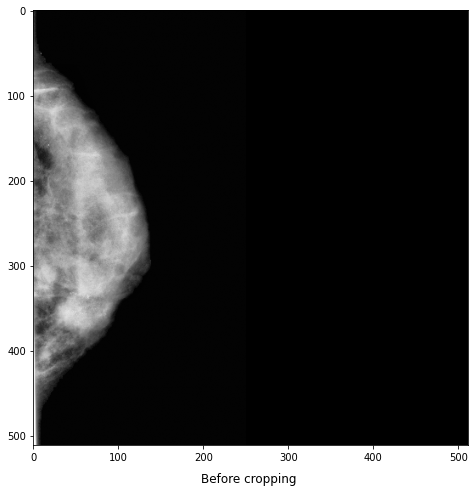

In [46]:
plt.figure(figsize = (50,8))
plt.imshow(res_x.numpy(), cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)

(512, 512, 3)


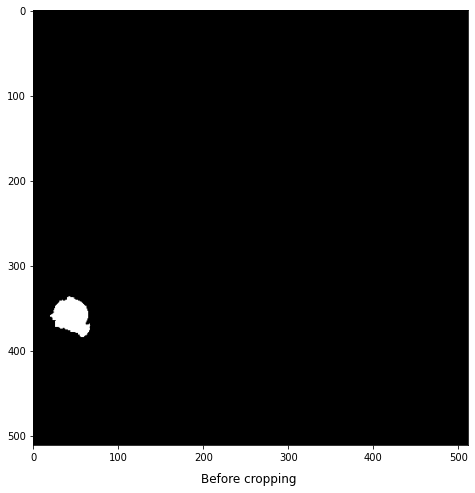

In [47]:
plt.figure(figsize = (50,8))
plt.imshow(res_y.numpy()[:,:,0], cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)
print(res_x.numpy().shape)

In [48]:
# res_y.numpy()[:,:,0].shape

In [49]:
# res_x.numpy().shape

In [50]:
prediction = unet.predict(test_ds)

In [51]:
# type(prediction)

In [52]:
# prediction.shape

In [53]:
# prediction[0].shape

(512, 512, 3)


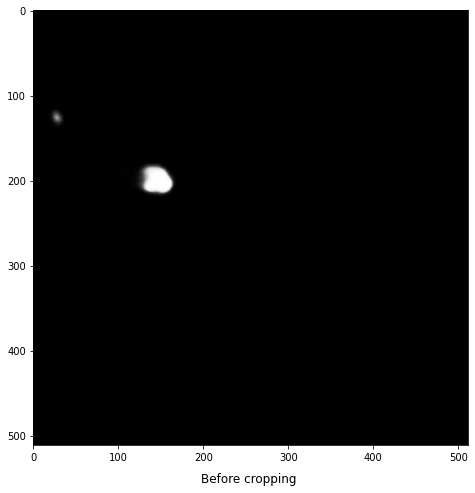

In [54]:
plt.figure(figsize = (50,8))
plt.imshow(prediction[i][:,:,0], cmap="gray")
plt.title(f"Before cropping ", x=0.5, y=-0.1)
print(res_x.numpy().shape)